# Load model

In [34]:
from keras.models import load_model
import pandas as pd
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

#change the name if needed
SAVE_NAME = "emoji-rgb.h5" #this model is 3-channels input to adapt LIME
model = load_model(SAVE_NAME)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
__________

# load training data

In [286]:
DIR_MAC="/Users/haipengwu/Codings/Machine Learning/HW3/"
DIR_1080="C:\\Users\\WIN10\\Codings\\Machine Learning\\HW3\\"

FILE_X_train="train.csv"
# FILE_y_train="Y_train"
FILE_X_test="test.csv"

#put directory info inside Run_machine
RUN_MACHINE =DIR_MAC

df_X_train = pd.read_csv(RUN_MACHINE+FILE_X_train, encoding='unicode_escape' ,sep=',',engine='python')
df_X_test = pd.read_csv(RUN_MACHINE+FILE_X_test, encoding='unicode_escape',sep=',',engine='python')

training_data = np.array(df_X_train)

training_num = 26000
validation_num = training_data.shape[0] - training_num

X_train=np.empty([training_num,48*48])
y_train =np.empty([training_num,1])

X_val=np.empty([validation_num,48*48])
y_val=np.empty([validation_num,1])

for i in range(training_data.shape[0]):
    if i<training_num:
        X_train[i]=training_data[i][1].split()
        y_train[i] = training_data[i][0]
    else:
        X_val[i - training_num]= training_data[i][1].split()
        y_val[i - training_num] = training_data[i][0]

X_train = X_train.reshape(-1,48,48)
y_train = y_train.reshape(-1,1)

X_val = X_val.reshape(-1,48,48)
y_val = y_val.reshape(-1,1)

testing_data = np.array(df_X_test)

X_test=np.empty([testing_data.shape[0],48*48])
for i in range(testing_data.shape[0]):
    X_test[i]=testing_data[i][1].split()
X_test = X_test.reshape(-1,48,48)

# Convert from Grayscale to RGB format for LIME, LIME needs 3 channels input

In [287]:
import skimage

X_train = skimage.color.gray2rgb(X_train)
X_val = skimage.color.gray2rgb(X_val)
X_test = skimage.color.gray2rgb(X_test)

In [228]:
y_test_pred = model.predict(X_test/255)
y_test_pred = np.argmax(y_test_pred,axis=1)
y_test_pred =y_test_pred.reshape(-1,1)

In [304]:
y_test_0 = model.predict_proba(np.expand_dims(X_test[0]/255,axis=0))
y_test_0_argmax = np.argmax(y_test_0)
y_test_0_argmax_val = y_test_0[0][y_test_0_argmax]
print(y_test_0, y_test_0_argmax, y_test_0_argmax_val)

[[8.6292806e-05 7.2263717e-08 9.0334615e-05 9.9777848e-01 6.1015715e-05
  4.3779745e-04 1.5459665e-03]] 3 0.9977785


# Saliency map function

In [214]:
class GradientSaliency():
    def __init__(self, model , output_index=0):
        input_tensors = [model.input]
        gradients = model.optimizer.get_gradients(model.output[0][output_index],model.input)
        self.compute_gradients = K.function(inputs = input_tensors, outputs=gradients)
    
    def get_mask(self, input_image):
        x_value = np.expand_dims(input_image,axis=0)
        gradients = self.compute_gradients([x_value])[0][0]
        return gradients

# Saliency map display

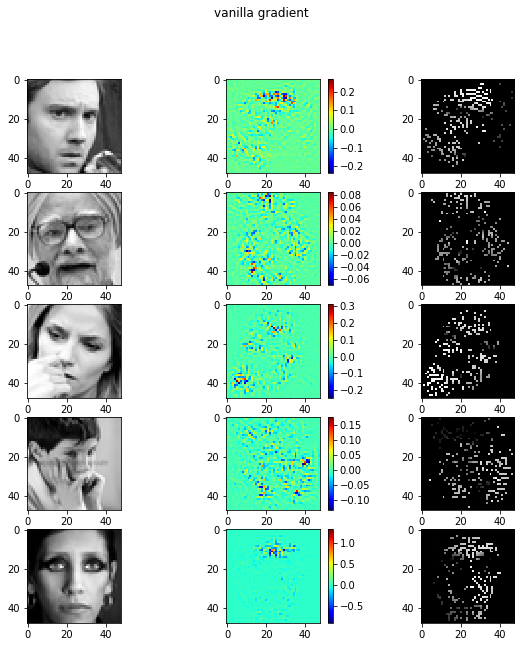

In [219]:
sample_num = 5

fig, ax = plt.subplots(sample_num, 3, figsize = (10, sample_num*2)) # set the width of the fig to adapt the number of subplots
fig.suptitle('vanilla gradient')
y_train = y_train.astype(np.int)

for i in range(sample_num):
    X_train[i] = X_train[i]/255
    img = X_train[i]
    vanilla = GradientSaliency(model,y_train[i][0])
    mask = vanilla.get_mask(img)
    
    img = skimage.color.rgb2gray(img) # convert back to grayscale
    mask = skimage.color.rgb2gray(mask) 
    
    filter_mask = (mask > (np.percentile(mask,90))) #> 85% of the total values
    ax[i, 0].imshow(img, cmap = 'gray')
    cax= ax[i, 1].imshow(mask, cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 1])
    ax[i, 2].imshow(img* filter_mask, cmap = 'gray')
    
plt.show()
plt.close()    


# LIME

In [288]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=48, compactness=1, sigma=1)

CPU times: user 1.63 s, sys: 808 ms, total: 2.44 s
Wall time: 568 ms


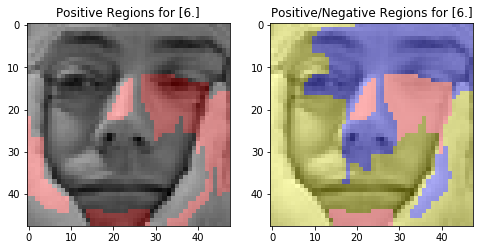

In [342]:
%%time
IMG_INDEX = 201

explanation = explainer.explain_instance(X_train[IMG_INDEX]/255, 
                                         classifier_fn = model.predict_proba, 
                                         top_labels=7, hide_color=0, num_samples=100, segmentation_fn=segmenter)

from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(y_train[IMG_INDEX][0], positive_only=True, num_features=7, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_train[IMG_INDEX]))
temp, mask = explanation.get_image_and_mask(y_train[IMG_INDEX][0], positive_only=False, num_features=10, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_train[IMG_INDEX]))

# Check for testing data

CPU times: user 1.58 s, sys: 753 ms, total: 2.34 s
Wall time: 564 ms


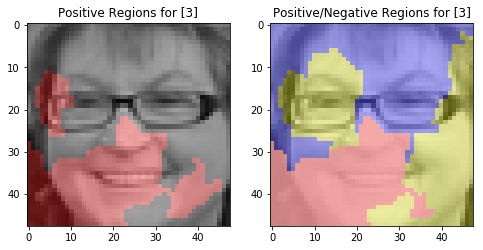

In [300]:
%%time
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=48, compactness=1, sigma=1)

IMG_INDEX = 0

explanation = explainer.explain_instance(X_test[IMG_INDEX]/255, 
                                         classifier_fn = model.predict_proba, 
                                         top_labels=7, hide_color=0, num_samples=100, segmentation_fn=segmenter)
from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(y_test_pred[IMG_INDEX][0], positive_only=True, num_features=7, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test_pred[IMG_INDEX]))
temp, mask = explanation.get_image_and_mask(y_test_pred[IMG_INDEX][0], positive_only=False, num_features=7, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test_pred[IMG_INDEX]))